# Answering Business Questions using SQL

In this Porject, I will be using SQL to answer business questions.
I'll use the Chinook database. The Chinook database is provided as a SQLite database file called `chinook.db`.

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

## Overview of the Data

I will start by getting familiar with the data. I will query the database to get a list of all tables and views in our database:

In [2]:
%%sql
SELECT name,
       type
  FROM sqlite_master
 WHERE type IN ("table", "view")

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


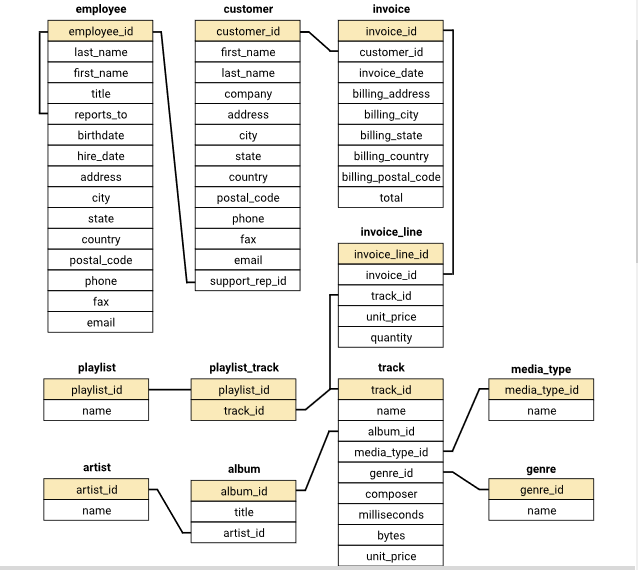

## Selecting Albums to Purchase

In [3]:
%%sql

WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


genre,tracks_sold,percentage_sold
Rock,561,0.5337773549000951
Alternative & Punk,130,0.12369172216936251
Metal,124,0.11798287345385347
R&B/Soul,53,0.05042816365366318
Blues,36,0.03425309229305423
Alternative,35,0.03330161750713606
Pop,22,0.02093244529019981
Latin,22,0.02093244529019981
Hip Hop/Rap,20,0.019029495718363463
Jazz,14,0.013320647002854425


Based on the sales of tracks across different genres in the USA, I would advise that should purchase the new albums by the following artists:

- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

In [4]:
%%sql

WITH customer_spend AS 
                        (
                        SELECT c.customer_id,
                               SUM(i.total) total,
                               c.support_rep_id sales_support
                          FROM customer c
                         INNER JOIN invoice i ON i.customer_id = c.customer_id
                         GROUP BY 1
                        )

SELECT e.first_name|| " " || e.last_name employee_name,
       e.hire_date,
       SUM(total) total_sales

  FROM customer_spend cs
 INNER JOIN employee e ON e.employee_id = cs.sales_support
 GROUP BY 1
 ORDER BY 3 DESC;

 * sqlite:///chinook.db
Done.


employee_name,hire_date,total_sales
Jane Peacock,2017-04-01 00:00:00,1731.5099999999998
Margaret Park,2017-05-03 00:00:00,1584.0000000000002
Steve Johnson,2017-10-17 00:00:00,1393.92


While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Sales by Country

In [5]:
%%sql

WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );

 * sqlite:///chinook.db
Done.


country,customers,total_sales,average_order,customer_lifetime_value
USA,13,1040.490000000008,7.942671755725252,80.03769230769292
Canada,8,535.5900000000034,7.047236842105309,66.94875000000043
Brazil,5,427.68000000000245,7.011147540983647,85.53600000000048
France,5,389.0700000000021,7.781400000000042,77.81400000000042
Germany,4,334.6200000000016,8.161463414634186,83.6550000000004
Czech Republic,2,273.24000000000103,9.108000000000034,136.62000000000052
United Kingdom,3,245.52000000000078,8.768571428571457,81.84000000000026
Portugal,2,185.13000000000022,6.3837931034482835,92.56500000000011
India,2,183.1500000000002,8.72142857142858,91.5750000000001
Other,15,1094.9400000000085,7.448571428571486,72.99600000000056


Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks

In [6]:
%%sql

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;

 * sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent
no,500,0.8143322475570033
yes,114,0.18566775244299674


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.